In [1]:
%reload_ext autoreload
%autoreload 2
import os

# Get the absolute path to the current working directory (project root)
path_codes = os.path.abspath(os.getcwd())
print(path_codes)

## Settings of results 
fontsize_text = 25
color_text = 'mediumseagreen'
fontsize_text = 12



# get the labels for imagenet
from Stimuli.load_stimuli import labels_imagenet


/home/tahereh/engram/users/Tahereh/Codes/Public_Codes/Generative_Inference_Perception
Kernel running on local computer 'demo'.
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark']
image names:  ('self', 'image_name', 'image_original', 'cmap')


/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/robustness/train.py:24: UserWarning: Could not import amp.
  warnings.warn('Could not import amp.')


In [11]:
import torch

# for face net: 'advrobust_L2_eps_0.50' checkpoint 100
class Args:
    def __init__(self) -> None:
        self.model_arch = 'resnet50' #'resnet18'#'resnext50-32x4d'#'resnet18' #'vgg16-bn' #'vgg16'#'resnet50'
        self.input_size = 224
        self.dataset_model = 'vggface2'  #'imagenetvggface2' #'imagenet' #'vggface2' # 'imagenetvggface2'#'vggface2' #'imagenet'
        self.model_training ='advrobust_L2_eps_0.50' ##'advrobust_L2_eps_0.50' #'advrobust_Linf_eps_4.00' #'advrobust_L2_eps_3.00' #'advrobust_Linf_eps_4.00' #'advrobust_L2_eps_0.50'  'advrobust_L2_eps_3.00' #
        
        # self.dataset_model =  'vggface2' #'imagenet' # 'imagenetvggface2'#'vggface2' #'imagenet'
        # self.model_training ='advrobust_L2_eps_0.50' ##'advrob
        
        # self.dataset_model =  'imagenetvggface2'#'vggface2' #'imagenet'
        # self.model_training ='advrobust_L2_eps_3.00' ##'advrob
        
        self.epoch_chkpnt = '150' #176 #100 #106 #100#'full' # 160 for vggface IncConfMSE #'full' 
        self.eval_dataset_identifier = 'vggface2_test'
        self.batch_size = 32


args = Args()

if args.dataset_model == 'vggface2':
    # assert args.model_training == 'advrobust_L2_eps_0.50'
    args. norm_mean = torch.tensor([0.5, 0.5, 0.5]).cuda()
    args.norm_std = torch.tensor([0.5, 0.5, 0.5]).cuda()
    args.n_classes = 500
elif 'imagenet' in  args.dataset_model or 'places365' in args.dataset_model:
    args.norm_mean = torch.tensor([0.485, 0.456, 0.406]).cuda()
    args.norm_std = torch.tensor([0.229, 0.224, 0.225]).cuda()
    args.n_classes = 1000
else:
    raise ValueError(f"Dataset model {args.dataset_model} not supported yet")
          

#'vggface2'  'advrobust_L2_eps_0.50' 'full' 'vggface2_test' 32
# Load the model -----------------------------
# Convert dictionary to object so load_models can access attributes
from types import SimpleNamespace
model_args = SimpleNamespace(**{
    'model_arch': args.model_arch, 
    'model_training': args.model_training,
    'input_size': args.input_size,
    'dataset': args.dataset_model,  # load_models expects 'dataset' not 'dataset_model'
    'epoch_chkpnt': args.epoch_chkpnt,
    'norm_mean': args.norm_mean,
    'norm_std': args.norm_std,
    'n_classes': args.n_classes,
    # 'inference': args.inference
})

from Models import load_models
model, _ = load_models.load_models(model_args)
model = torch.nn.DataParallel(model).cuda()
_=model.eval()


/home/tahereh/engram/users/Tahereh/Codes/Public_Codes/Generative_Inference_Perception
namespace(model_arch='resnet50', model_training='advrobust_L2_eps_0.50', input_size=224, dataset='vggface2', epoch_chkpnt='150', norm_mean=tensor([0.5000, 0.5000, 0.5000], device='cuda:0'), norm_std=tensor([0.5000, 0.5000, 0.5000], device='cuda:0'), n_classes=500)
load_path: /home/tahereh/engram/users/Tahereh/Codes/Perceptually_Aligned_Gradients/Training/TrainedModels/train_resnet50_vggface2_eps_0.50/3140bf7b-21a2-41dd-9ace-9407fcfc2137/150_checkpoint.pt
****** Loading model from /home/tahereh/engram/users/Tahereh/Codes/Perceptually_Aligned_Gradients/Training/TrainedModels/train_resnet50_vggface2_eps_0.50/3140bf7b-21a2-41dd-9ace-9407fcfc2137/150_checkpoint.pt after adjusting the model architecture
=> loading checkpoint '/home/tahereh/engram/users/Tahereh/Codes/Perceptually_Aligned_Gradients/Training/TrainedModels/train_resnet50_vggface2_eps_0.50/3140bf7b-21a2-41dd-9ace-9407fcfc2137/150_checkpoint.pt'


In [ ]:
## test the generative inference function
from Stimuli.load_stimuli import ImageLoader
from Inference.Generative_infernece import generative_inference

# Convert SimpleNamespace back to dict for unpacking
model_args_dict = vars(model_args)
model_config = {'model': model, 'dataset_model': args.dataset_model, **model_args_dict}
## pretty print the model_config
inference_config = {'loss_infer':'PGDD' ,#'IncreaseConfidence',## 'PGDD',# #'IncreaseConfidence', #'PGDD', 
                    'loss_function': 'MSE',#'CE',
                    'n_itr':201, 
                    'eps': 40, #0.5, 
                    'step_size': 0.2, #3
                    'diffusion_noise_ratio': 0.01,#0.05, 
                    'initial_inference_noise_ratio': 0.5,#,05, #0.1, 
                    'iterations_to_show': [0, 1, 2, 4, 8, 16, 20, 24, 32, 40,  48,  56, 72, 80, 192, 200],
                    'top_layer': 'layer4',#'global_pool', #'layer4', #'avgpool', #'all',
                    'inference_normalization': 'off',
                    'recognition_normalization': 'off',
                    'misc_info': {'keep_grads': True,}
                    }



image_name = 'FaceVaseWhite' #'FaceVase' #'FaceVaseWhite'
image, cmap = ImageLoader(args.dataset_model).load_image(image_name)


selected_inferred_patterns, perceived_categories, confidence_list, misc_info_dict = generative_inference(model_config, image, inference_config)
iteration_numbers = inference_config['iterations_to_show']
if inference_config['misc_info']['keep_grads']:
    selected_grad_patterns = misc_info_dict['grad_info']
else:
    selected_grad_patterns = []

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

/home/tahereh/anaconda3/envs/robustbenchpy311/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


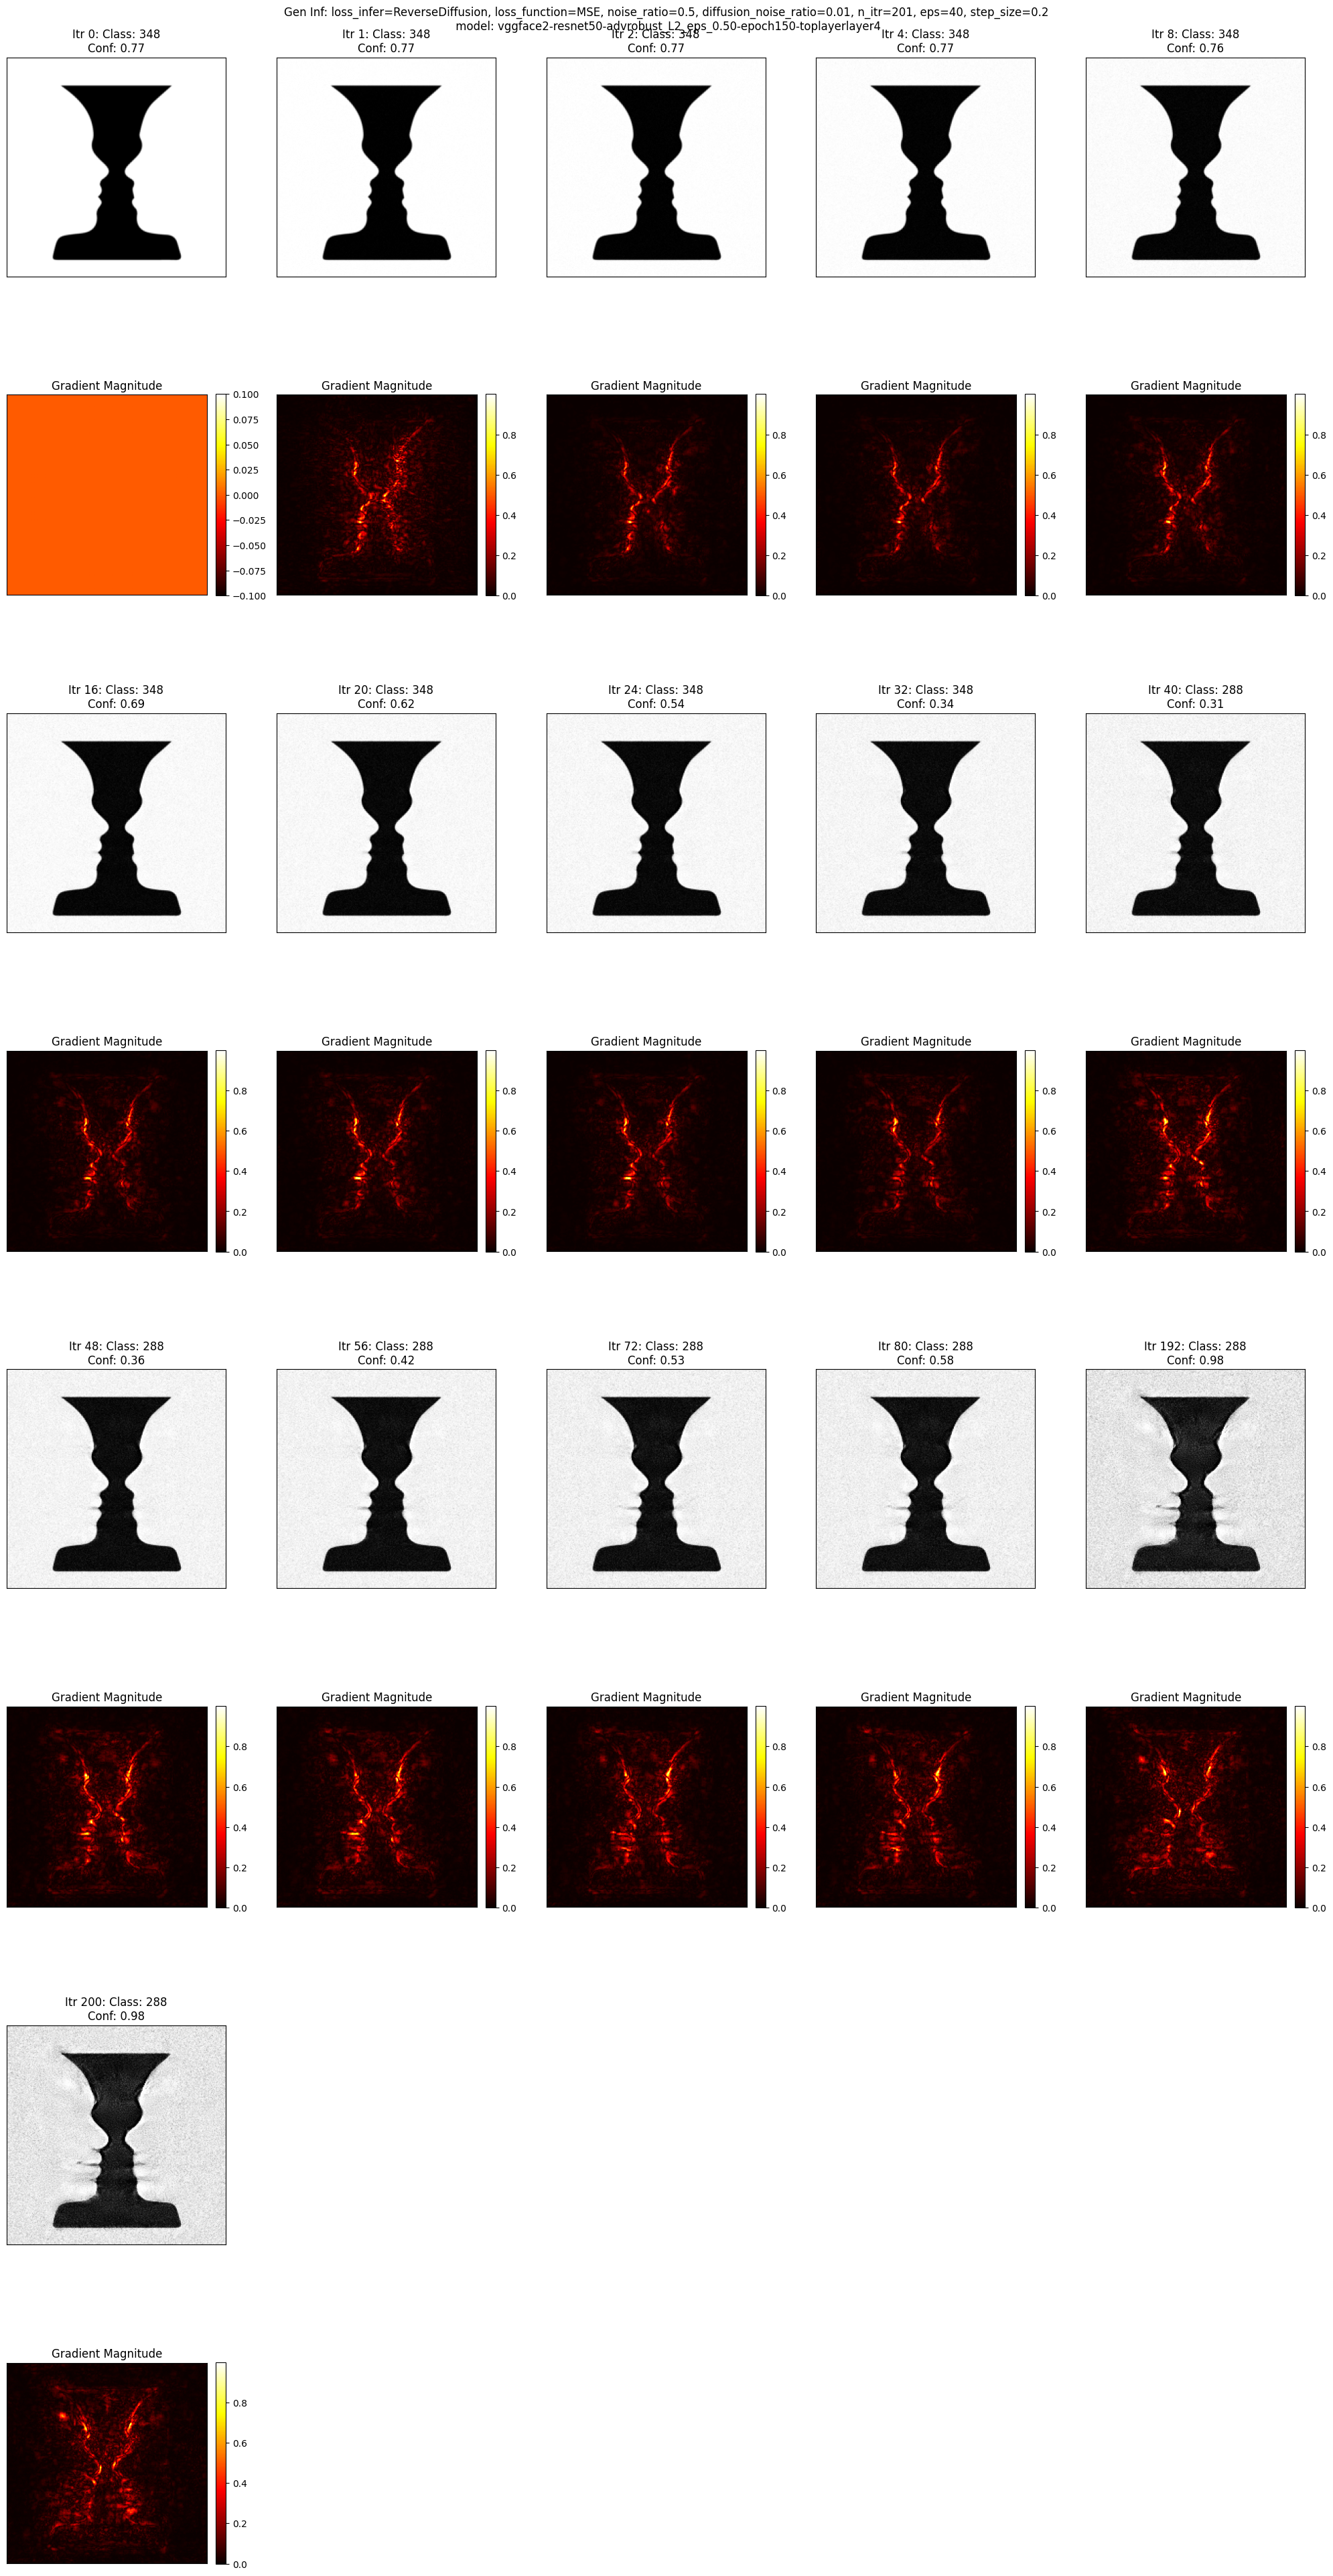

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

# show the images and gradients in a grid - now with 2 rows per pattern
n_cols = 5
n_pattern_rows = len(selected_inferred_patterns)//n_cols + (1 if len(selected_inferred_patterns)%n_cols > 0 else 0)
if n_pattern_rows == 0:
    n_pattern_rows = 1
# Double the rows to accommodate gradients below each image
n_total_rows = n_pattern_rows * 2
fig, axes = plt.subplots(n_total_rows, n_cols, figsize=[20, 5*n_pattern_rows * 2])

if model_config['dataset_model'] == 'vggface2':
    norm_mean = torch.tensor([0.5,0.5,0.5]).view(-1, 1, 1).cuda()
    norm_std = torch.tensor([0.5,0.5,0.5]).view(-1, 1, 1).cuda()
elif model_config['dataset_model'] == 'imagenet' or model_config['dataset_model'] == 'imagenetvggface2':
    norm_mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).cuda()
    norm_std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).cuda()

for i in range(len(selected_inferred_patterns)):
    # Calculate positions for image and gradient
    row_idx = (i // n_cols) * 2  # Multiply by 2 to skip rows for gradients
    col_idx = i % n_cols
    
    # Get axes for both image and gradient
    if n_pattern_rows == 1:
        ax_img = axes[0] if n_cols == 1 else axes[col_idx]
        ax_grad = axes[1] if n_cols == 1 else axes[n_cols + col_idx]
    else:
        ax_img = axes[row_idx, col_idx]
        ax_grad = axes[row_idx + 1, col_idx]
        
    # Get the image and corresponding gradients
    image_to_compute = selected_inferred_patterns[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
    gradients = selected_grad_patterns[i].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
    
    # Normalize gradients for visualization
    grad_magnitude = np.sqrt(np.sum(gradients**2, axis=2))
    grad_normalized = (grad_magnitude - grad_magnitude.min()) / (grad_magnitude.max() - grad_magnitude.min() + 1e-8)
        
    
    predicted_emotion = 'N/A'
    confidence_emotion = 0
    first_itr_conf_got_high = 0
    emotion_detected = False
    color_title = 'black'
    
    # Plot image in top subplot
    if cmap=='gray':
        image_to_compute_in_gray = np.mean(image_to_compute, axis=2)
        ax_img.imshow(image_to_compute_in_gray, cmap='gray')
    else:
        ax_img.imshow(image_to_compute, cmap=cmap)
    # Plot gradient heatmap in bottom subplot
    gradient_plot = ax_grad.imshow(grad_normalized, cmap='hot')
    plt.colorbar(gradient_plot, ax=ax_grad, fraction=0.046, pad=0.04)
    
    # Set titles
    if model_config['dataset_model'] == 'imagenet':
        ax_img.set_title(f'Itr {iteration_numbers[i]}: Class: {labels_imagenet[perceived_categories[i]]}\nConf: {confidence_list[i]:.2f}', color=color_title)
    else:
        ax_img.set_title(f'Itr {iteration_numbers[i]}: Class: {perceived_categories[i]}\nConf: {confidence_list[i]:.2f}', color=color_title)
    
    ax_grad.set_title('Gradient Magnitude')
    
    # Remove ticks from both subplots
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    ax_grad.set_xticks([])
    ax_grad.set_yticks([])

fig.suptitle(f'Gen Inf: loss_infer={inference_config["loss_infer"]}, loss_function={inference_config["loss_function"]}, noise_ratio={inference_config["initial_inference_noise_ratio"]}, diffusion_noise_ratio={inference_config["diffusion_noise_ratio"]}, n_itr={inference_config["n_itr"]}, eps={inference_config["eps"]}, step_size={inference_config["step_size"]}\n model: {args.dataset_model}-{args.model_arch}-{args.model_training}-epoch{args.epoch_chkpnt}-toplayer{inference_config["top_layer"]}')

# Remove empty axes
for i in range(n_total_rows):
    for j in range(n_cols):
        pattern_idx = (i//2) * n_cols + j
        if pattern_idx >= len(selected_inferred_patterns):
            if n_pattern_rows > 1:
                fig.delaxes(axes[i, j])

plt.tight_layout()
plt.show()

# # Save figure
# figsave_dir = os.path.join(resultsdir, f'{args.dataset_model}-{args.model_arch}-{args.model_training}-{args.epoch_chkpnt}/')
# if not os.path.exists(figsave_dir):
#     os.makedirs(figsave_dir)

# fig_name = f'{image_name}_{inference_config["top_layer"]}_geninf_{model_config["dataset_model"]}_{model_config["model_arch"]}_{model_config["model_training"]}_epoch{model_config["epoch_chkpnt"]}_{inference_config["loss_infer"]}_{inference_config["loss_function"]}_noise_ratio{inference_config["initial_inference_noise_ratio"]}_diffusion_noise_ratio{inference_config["diffusion_noise_ratio"]}_n_itr{inference_config["n_itr"]}_eps{inference_config["eps"]}_step_size{inference_config["step_size"]}'
# fig_name = fig_name + f'_confitr{first_itr_conf_got_high}_{emotion_detected}_with_gradients'

# instance_counter = 0
# while os.path.exists(os.path.join(figsave_dir, fig_name+'.pdf')):
#     print('file already exists, adding instance number')
#     if 'instance' in fig_name:
#         fig_name = fig_name.split('_instance')[0]
#     fig_name = fig_name + f'_instance{instance_counter}'
#     instance_counter += 1

# fig.savefig(os.path.join(figsave_dir, fig_name+'.pdf'), dpi=300, bbox_inches='tight')
# print('saved at:', os.path.join(figsave_dir, fig_name+'.pdf'))

# # Save results dictionary
# dict_results = {
#     'model_config': model_config,
#     'inference_config': inference_config,
#     'selected_inferred_patterns': selected_inferred_patterns,
#     'selected_grad_patterns': selected_grad_patterns,
#     'perceived_categories': perceived_categories,
#     'iteration_numbers': iteration_numbers,
# }
# np.save(os.path.join(figsave_dir, fig_name+'.npy'), dict_results)